In [31]:
import numpy as np
import networkx as nx
import datetime
import matplotlib.pyplot as plt

In [4]:
#zadanie 1
#Funkcja działająca na macierzach zaimplementowanych w numpy
def gauss_solve(A):
    inversions=[i for i in range(len(A))]
    for i in range(len(A)):
        max_i=i
        for j in range(i,len(A)):
            if abs(A[max_i][i])<abs(A[j][i]):
                max_i = j
        best_row=np.copy(A[max_i])
        A[[i,max_i]]=A[[max_i,i]]#Zamieniam wiersze miejscami, tak, aby na górze było zawsze to o największej wartości bezwzględnej
        inversions[i],inversions[max_i]=inversions[max_i],inversions[i]
        for j in range(i+1,len(A)):
            first_non_zero=A[j][i]
            A[j]-=best_row*first_non_zero/best_row[i]
    #uzyskałem macierz trójkątną górną
    #teraz z niej uzyskuję wyniki
    for i in range(len(A)-1,-1,-1):
        for j in range(i-1,-1,-1):
            last_non_zero=A[j][i]
            A[j]-=A[i]*last_non_zero/A[i][i]
    for i in range(len(A)):
        A[i]/=A[i][i]
    result=A[:,-1]
    result1=np.zeros((len(A),))
    for i,r in enumerate(inversions):
        result1[r]=result[i]
    return result

In [5]:
M=np.random.random((30,31))

In [6]:
M

array([[6.62515422e-01, 1.41090591e-01, 9.48488245e-01, 5.88595221e-01,
        2.18806316e-01, 7.36598354e-02, 5.54776956e-01, 9.70308068e-02,
        8.21765837e-01, 3.95645118e-01, 1.52401498e-03, 9.74503109e-01,
        8.93283227e-01, 1.95964862e-02, 1.21047600e-01, 5.55772617e-01,
        9.20860533e-01, 2.51381903e-01, 6.57878167e-01, 9.36379161e-01,
        4.56683307e-01, 5.70364993e-01, 9.13152334e-01, 9.15026813e-01,
        2.62363674e-01, 1.79996902e-01, 9.44172846e-02, 2.19982564e-01,
        6.36849728e-01, 4.60631622e-01, 8.31650580e-01],
       [5.26925627e-01, 3.65409058e-01, 3.83701753e-01, 9.72739528e-01,
        7.40971024e-02, 5.32709563e-01, 6.19361670e-01, 8.86319692e-01,
        3.62004677e-01, 2.66231979e-01, 4.49782675e-01, 5.77891029e-01,
        6.70183663e-01, 9.60620308e-01, 4.48425748e-01, 7.46551153e-01,
        1.66840151e-01, 9.08832357e-01, 6.42296010e-01, 7.57941917e-01,
        8.87451061e-01, 2.98441044e-01, 9.62838538e-01, 1.97559304e-01,
       

In [9]:
result=gauss_solve(np.copy(M))
print(result)

[ 0.36266703  0.88559902 -1.16499224  0.50204804 -0.69041151  0.55382147
  1.96235831 -0.54608752  0.42847777  0.17459976  0.22321694  0.6153737
 -0.20757573  2.05752291 -0.95603949 -0.07982809  1.91711368 -1.4087088
 -0.61842243 -0.12444501  0.22319811  1.18951466 -1.34729309 -0.1360064
 -0.60804613  1.74517652 -1.53124189 -0.03687417  0.050634   -1.54836898]


In [10]:
M[:,-1]#B

array([0.83165058, 0.46941065, 0.8882635 , 0.80015607, 0.42659698,
       0.40302821, 0.83992031, 0.88537064, 0.01674896, 0.20058288,
       0.81582026, 0.74204592, 0.34733649, 0.29204571, 0.28184193,
       0.20399191, 0.63638437, 0.34149066, 0.98002074, 0.74695506,
       0.87635597, 0.74848527, 0.13492398, 0.41639099, 0.86673585,
       0.37654783, 0.38016551, 0.72508199, 0.83076695, 0.58116839])

In [11]:
np.dot(np.copy(M)[:,:30],result.reshape(30,1))#Mnożę macierz współczynników, przez wektor wyniku,
#aby zweryfikować go. Wychodzi równy ostatniej kolumnie macierzy

array([[0.83165058],
       [0.46941065],
       [0.8882635 ],
       [0.80015607],
       [0.42659698],
       [0.40302821],
       [0.83992031],
       [0.88537064],
       [0.01674896],
       [0.20058288],
       [0.81582026],
       [0.74204592],
       [0.34733649],
       [0.29204571],
       [0.28184193],
       [0.20399191],
       [0.63638437],
       [0.34149066],
       [0.98002074],
       [0.74695506],
       [0.87635597],
       [0.74848527],
       [0.13492398],
       [0.41639099],
       [0.86673585],
       [0.37654783],
       [0.38016551],
       [0.72508199],
       [0.83076695],
       [0.58116839]])

In [135]:
sizes=[600+200*i for i in range(10)]

In [136]:
own_times=[]
lib_times=[]
for s in sizes:
    M=np.random.random((s,s+1))
    start=datetime.datetime.now()
    A=gauss_solve(M)
    stop=datetime.datetime.now()
    own_times.append((stop-start).microseconds//1000)#datetime ma dokładność do nanosekund, więc ucinam zera na końcu
    start=datetime.datetime.now()
    A=np.linalg.solve(M[:,:s],M[:,-1])
    stop=datetime.datetime.now()
    lib_times.append((stop-start).microseconds//1000)

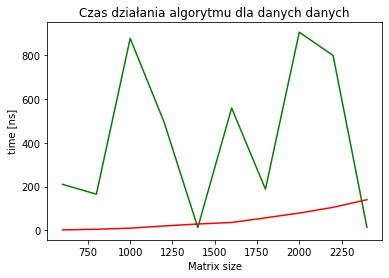

In [138]:
plt.plot(sizes,own_times,color='green')
plt.plot(sizes,lib_times,color='red')
plt.title("Czas działania algorytmu dla danych danych")
plt.xlabel("Matrix size")
plt.ylabel("time [ns]")
plt.show()

In [27]:
#zadanie 2
#faktoryzacja macierzy kwadratowej metodą Doolittle'a
def factorize(M):
    size=M.shape[0]
    L=np.identity(size)
    U=np.zeros((size,size))
    for i in range(size):
        for j in range(i,size):
            sub_sum=0
            for k in range(i):
                sub_sum+=L[i][k]*U[k][j]
            U[i][j]=M[i][j]-sub_sum
        for j in range(i+1,size):
            sub_sum=0
            for k in range(i):
                sub_sum+=L[j][k]*U[k][i]
            L[j][i]=(M[j][i]-sub_sum)/U[i][i]
    return L,U

In [28]:
M=np.array([[5,3,2],[1,2,0],[3,0,4]])
print(M)
print(factorize(M)[0])
print(factorize(M)[1])

[[5 3 2]
 [1 2 0]
 [3 0 4]]
[[ 1.          0.          0.        ]
 [ 0.2         1.          0.        ]
 [ 0.6        -1.28571429  1.        ]]
[[ 5.          3.          2.        ]
 [ 0.          1.4        -0.4       ]
 [ 0.          0.          2.28571429]]


array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [30]:
M=np.random.random((5,5))
L,U=factorize(M)
print(M-np.dot(L,U))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.11022302e-16 -2.66453526e-15  6.66133815e-16
  -2.44249065e-15]
 [ 0.00000000e+00  0.00000000e+00  5.55111512e-16  3.33066907e-16
   2.88657986e-15]
 [ 1.11022302e-16  0.00000000e+00 -1.33226763e-15  8.88178420e-16
  -1.33226763e-15]]


# Możemy uznać, że funkcja factorize działa poprawnie.
W każdym wierszu w każdej kolumnie wychodzą wartośći 0 lub bliskie 0.

### zadanie 3
a)
Plik zawierający graf musi mieć postać:<br>
v1 u1 w1<br>
v2 u2 w2<br>
v3 u3 w3<br>
.  .  .<br>
.  .  .<br>
gdzie ui i vi to wierzcholki grafu, a wi to wagi krawędzi między nimi

In [32]:

def read_graph(name):
    L=[]
    with open(name,'r') as file:
        lines=file.readlines()
        for l in lines:
            s=l.split()
            u,v,w=int(s[0]),int(s[1]),int(s[2])
            L.append((u,v,w))
    G=nx.Graph()
    for u,v,w in L:
        G.add_edge(u-1, v-1, weight=w)
    return G

In [107]:
def random_graph(n):
    G=nx.gnm_random_graph(n,np.random.randint(n,n*(n-1)//2))
    for e in G.edges():
        G[e[0]][e[1]]['weight']=np.random.random()
    return G

In [79]:
def cycles(G):
    #Biblioteczna funkcja cycle_basis zwraca tylko cykle rozłączne.
    #Jest ich dokładnie tyle, aby nasz układ równań był określony.
    return [[i for i in c] for c in nx.cycle_basis(G)]

In [281]:
#R=U/I
#I=U/R
#U=R*I
def prepare_matrix(G,s,t,E):
    weights=nx.get_edge_attributes(G,'weight')
    if not (G.has_edge(s,t)or G.has_edge(t,s)):
        G.add_edge(s,t)
    n_list=[[n for n in G.neighbors(i)]for i in range(len(G))]
    edges=[ t for t in G.edges()]
    edges_dict=dict()
    n=len(n_list)
    m=len(edges)
    for i in range(m):
        edges_dict[edges[i]]=i
    c=cycles(G)
    A=np.zeros((m+1,m+1))
    B=np.zeros((m+1,))
    #dodaję do układu równań równania wynikające z drugiego prawa kirchoffa
    for i in range(len(c)):
        cycle=c[i]
        cycle_edges=zip(cycle,cycle[1:]+[cycle[0]])
        for e in cycle_edges:
            norm_e=(min(e),max(e))
            if e == (s,t):
                B[i]= -E
            elif e == (t,s):
                B[i]= E
            else:
                e_index=edges_dict[norm_e]
                if e in edges_dict:
                    A[i][e_index]=weights[norm_e]
                else:
                    A[i][e_index]=-weights[norm_e]
    #dodaję do układu równań równania wynikające z pierwszego prawa kirchoffa
    for i in range(n):
        for j in n_list[i]:
            if j>i:
                e=(i,j)
                e_index=edges_dict[e]
                A[len(c)+i,e_index]=1
            else:
                e=(j,i)
                e_index=edges_dict[e]
                A[len(c)+i,e_index]=-1
    return A[:m,:m],B[:m],edges_dict
            

In [339]:
def show(G,e,I):
    I_graph=G.copy(as_view=True)
    for edge in I_graph.edges():
        I_graph[edge[0]][edge[1]]['weight']=I[e[edge]]
    edges,weights = zip(*nx.get_edge_attributes(I_graph,'weight').items())
    pos = nx.spring_layout(I_graph)
    nx.draw(I_graph, pos,,with_labels=True, node_color='b', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.summer)

SyntaxError: invalid syntax (548006337.py, line 7)

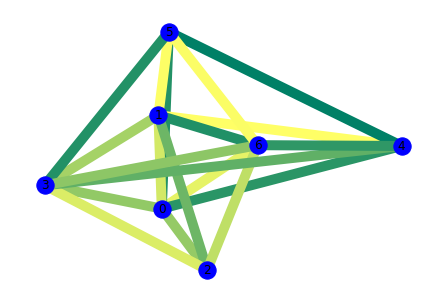

In [341]:
G=random_graph(7)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='b',with_labels=True, edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.summer)
A,B,e=prepare_matrix(G,0,1,2)
I=np.linalg.solve(A,B)

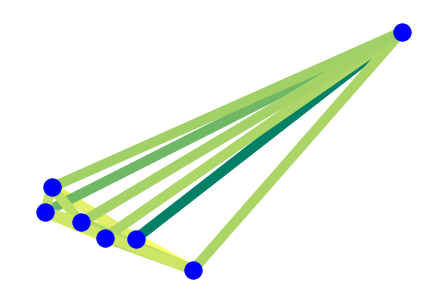

In [342]:
show(G,e,I)

In [265]:
A

array([[ 0.        ,  0.21619676,  0.        , -0.45280125,  0.        ,
         0.        ],
       [ 0.85880077,  0.        ,  0.        ,  0.        , -0.767896  ,
         0.        ],
       [ 0.85880077, -0.21619676,  0.        ,  0.        ,  0.        ,
         0.52457972],
       [ 1.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -1.        ,  1.        ,  1.        ,
         0.        ],
       [-1.        ,  0.        ,  0.        ,  0.        , -1.        ,
         1.        ]])

In [246]:
G.edges

EdgeView([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3)])

In [328]:
def visualize(G):
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color='b', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.summer)

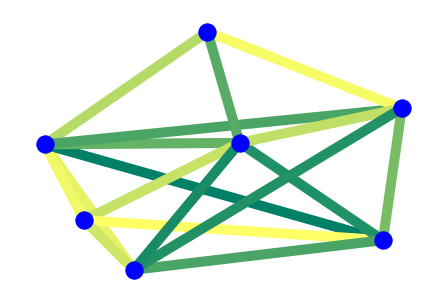

In [331]:
visualize(G)